# Reading in LIGO data for GW170817

*I grabbed figure 1 from here : https://www.ligo.org/detections/GW170817/paper/GW170817-PRLpublished.pdf , saved as LIGO.png,  and used WebPlotDigitier: https://apps.automeris.io/wpd/, and saved as digitized.csv.*

*Now I want to interpolate and return a smooth clean curve*

*Also note: the [timeline](https://www.ligo.org/science/Publication-GW170817MMA/images/timeline.png) says that gamma rays came about 30 seconds after merger, and then optical came about 0.4 days after merger.*

In [1]:
import pandas as pd
import numpy as np
from scipy.interpolate import InterpolatedUnivariateSpline
from scipy.optimize import curve_fit

import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML

%matplotlib inline

In [2]:
df = pd.read_csv('digitized.csv')
df.sort_values(by="t", inplace=True)
df['t'] -= 0.5
df

,t,f
7,-27.755022,37.571047
8,-25.823567,38.517856
9,-24.138519,39.488526
10,-21.548286,41.849617
11,-18.795053,43.261667
12,-17.149802,45.469573
13,-15.012585,47.003763
14,-13.530758,50.229185
15,-12.462150,51.069547
0,-11.215022,52.146935


*Fit a simple powerlaw to these data points to get a smooth curve*

[1.38504943e-05 3.73532968e-01]


/Users/ageller/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in power
  


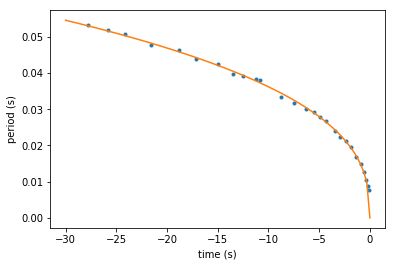

In [3]:
def periodFunc(t, a, b):
    return (-a*t)**b

period = 2./df['f'].values #I think this value of two is correct (and this is a period in seconds??)
tArr = np.linspace(-30, 0, 100)

popt, pcov = curve_fit(periodFunc, df['t'].values, period)
print(popt)
pFit = periodFunc(tArr, *popt)

f,ax= plt.subplots()
ax.plot(df['t'].values, period, '.')
ax.set_xlabel('time (s)')
ax.set_ylabel('period (s)')
plt.plot(tArr, pFit)

*Write this to a "raw" file (Not necessary if I use the power law for period)*

In [4]:
import csv
csvfile = open("GW170817_period.raw", 'wt')
csvwriter = csv.writer(csvfile, delimiter=' ', quotechar='|', quoting=csv.QUOTE_MINIMAL)
for i in range(len(tArr)):
    csvwriter.writerow([tArr[i],pFit[i], 3., 4., 5., 6., 7., 8., 9.])
csvfile.close()

### Test using this to generate 3D positions for a binary over time

*Note this [factsheet](https://www.ligo.org/detections/GW170817/images-GW170817/GW170817_Factsheet.pdf) for the LIGO event has some useful parameters.*

In [5]:
def getbinxyz(xb,m1,m2,ecc,per,omega,pi,zi,tim):
#from an old IDL code of mine, used for generating binary orbits for N-body
#working in units of solar mass, km, s

# calculate the semi-major axis    
    #G = 2942.206217504419 #solRad**3 / (day**2 solMass)
    G = 132712440000.0 #km**3 / (s**2 solMass)
    semi = ((per**2. * G * (m1 + m2) / (4. * np.pi**2.))**(1./3.))

#Set values at aopcentre. 
    xorb = [semi*(1.0 + ecc), 0.]
    
# Set transformation elements (Brouwer & Clemence p. 35).
# also Murray & Dermott page 51
# O=pi
# w=omega
# I=zi
    px = np.zeros(3)
    qx = np.zeros(3)
    f=(tim % per)/per*2.*np.pi
    px[0] = np.cos(pi)*np.cos(omega + f) - np.sin(pi)*np.sin(omega + f)*np.cos(zi)
    qx[0] =-np.sin(pi)*np.cos(omega + f) - np.cos(pi)*np.sin(omega + f)*np.cos(zi)
    px[1] = np.sin(pi)*np.cos(omega + f) + np.cos(pi)*np.sin(omega + f)*np.cos(zi)
    qx[1] =-np.cos(pi)*np.cos(omega + f) + np.sin(pi)*np.sin(omega + f)*np.cos(zi)
    px[2] = np.sin(omega + f)*np.sin(zi)
    qx[2] = np.cos(omega + f)*np.sin(zi)
    
# Transform to relative variables.
    xrel = px*xorb[0] + qx*xorb[1]

# calculate the true xyz positions
    xsb = np.zeros((3,2))
    xsb[:,0] = xb + m2*xrel/(m1+m2)
    xsb[:,1] = xsb[:,0] - xrel

    return xsb[:,0], xsb[:,1]

[-25.45926517 -12.05015583   0.        ] [41.66061573 19.71843682  0.        ]


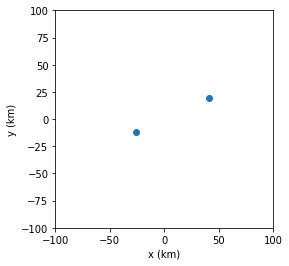

In [6]:
df = pd.read_csv('GW170817_period.raw', sep=' ', header=None, names=['t','p','f3','f4','f5','f6','f7','f8','f9'])
xb = [0., 0., 0.]
m1 = 1.8
m2 = 1.1
ecc = 0.
omega = 0.
pi = 0.
zi = 0.

i=0
time = -0.1
per = periodFunc(time, *popt)

pos1, pos2 = getbinxyz(xb,m1,m2,ecc,per,omega,pi,zi,time)
print(pos1, pos2)
f,ax = plt.subplots()
ax.set_xlim(-100,100)
ax.set_ylim(-100,100)
ax.set_aspect('equal')
ax.set_xlabel('x (km)')
ax.set_ylabel('y (km)')
ax.plot([pos1[0], pos2[0]], [pos1[1], pos2[1]],'o')


*Check the results by plotting over time*

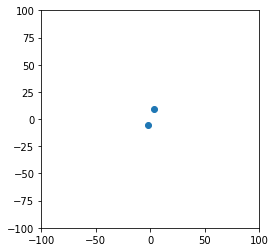

In [7]:
#First set up the figure, the axis, and the plot element we want to animate
Nframes = 500
tmin = -0.1
per = periodFunc(tmin, *popt)
pos1, pos2 = getbinxyz(xb,m1,m2,ecc,per,omega,pi,zi,tmin)

f,ax = plt.subplots()
ns, = ax.plot([pos1[0], pos2[0]], [pos1[1], pos2[1]],'o')
ax.set_xlim(-100,100)
ax.set_ylim(-100,100)
ax.set_aspect('equal')

# initialization function: plot the background of each frame
def init():
    ns.set_data([], [])
    return ns,

# animation function.  This is called sequentially

def animate(i, Nframes=Nframes, tmin=tmin):
    time = tmin*(1. - i/Nframes)
    per = periodFunc(time, *popt)
    pos1, pos2 = getbinxyz(xb,m1,m2,ecc,per,omega,pi,zi,time)
    ns.set_data([pos1[0], pos2[0]], [pos1[1], pos2[1]])
    return ns,

# call the animator. 
anim = animation.FuncAnimation(f, animate, init_func=init, frames=Nframes, interval=40, blit=True)

#display in the notebok
HTML(anim.to_html5_video())

# save the animation as an mp4. 
#anim.save('basic_animation.mp4', fps=30, extra_args=['-vcodec', 'libx264'])

